In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants.constants import C2K, K2C

#from flow_stress.flow_stress import FlowStressCalculator#, plot_strain_slip_rates
from flow_stress.gird import *


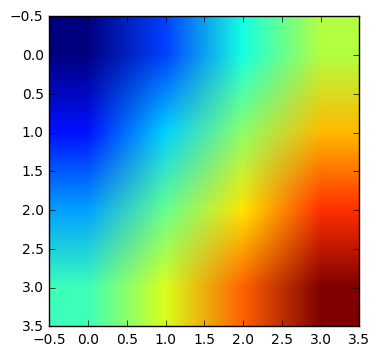

In [2]:
#Learning MeshGrid 


# tt, pp = np.meshgrid(np.linspace(300, 400, 25), np.linspace(100, 600, 25))
# tt_K = C2K(np.array(tt))
# pp_P = np.array(pp)*1.0E6
# tt.shape


tt, pp = np.meshgrid(np.linspace(300, 306, 3), np.linspace(400, 406, 3))
#print tt

a = np.linspace(300, 306, 4)
b = np.linspace(400, 406, 4)
aa, bb = np.meshgrid(a, b)
# print(aa)
# print(bb)

cc = aa*bb
plt.imshow(cc)
plt.show()

In [12]:
from matplotlib.backends.backend_pdf import PdfPages
from flow_stress.flow_stress import export_pdf

# fig = plot_strain_slip_rates(f.temperature, strain_rate, slip_rate)
# fig.set_size_inches(9,6)
# export_pdf(fig, 'strain_slip_rates')

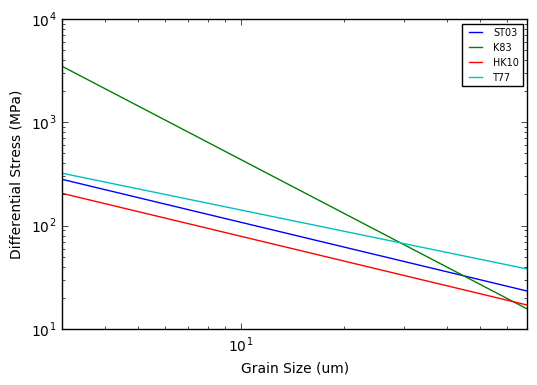

In [7]:
#plotting piezometers
import matplotlib.pyplot as plt
from flow_stress.flow_stress import PIEZOMETERS, FLOW_LAWS
temp = [450]
grain_size =range(3,70)
pressure = [400]

fig = plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Grain Size (um)')
plt.ylabel('Differential Stress (MPa)')

for key in PIEZOMETERS:
    f = FlowStressCalculator(temp,pressure)
    f.calculate_fugacity()
    ds = f.calculate_differential_stress(grain_size, paleopiezometer = key)

    plt.plot(grain_size, ds, label=key)
    plt.xlim([min(grain_size),max(grain_size)])

    
plt.legend(loc='upper right', fontsize = 'x-small')
plt.show()

In [3]:
from flow_stress.pt_conditions import PTCalculator

In [36]:
depth = range(20,25)
density = 2.9
geothermal_gradient = 30
grain_size = range(2,70)


p, t= PTCalculator(depth, density, geothermal_gradient).pt_calculator()
print p
print t

[568.4000000000001, 596.8200000000002, 625.2400000000001, 653.6600000000001, 682.0800000000002]
[600, 630, 660, 690, 720]


In [9]:
#EXTRA STUFF, that might be of interest from other notebooks

#HOW TO, Share plot x axis
plt.setp(sub1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace = 0.001)

#HOW TO, iterate through linestyles
colors = iter(cm.gray(np.linspace(0, 1, len(v))))#set color ramp to jet with a line spacing of length e
lstyles=[':', '-.', '--', '-', ':', '-.', '--', '-',':' ]

#HOW TO, write a test without testtutils

s = 84

T = temp_conv(450)

x = np.power(s,4)
y = np.power(300,1)
z = np.exp(-135000/(8.3144598*T))
e = 6.3E-12*x*y*z
v = 30000*31536000*e

#how to write a test!
def test_calculate_slip_rate():
    w = 30000
    e = 2.043722042401592e-11
    slip_rate = calculate_slip_rate(e, w)
    assert slip_rate == 19.335245498752982
test_calculate_slip_rate()



NameError: name 'sub1' is not defined